<a href="https://colab.research.google.com/github/aleksejalex/temp_rndmtx/blob/main/TNM_lec1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import numpy as np
import scipy as scp
import sympy as sp
import seaborn as sbn
import matplotlib.pyplot as plt
import pickle

In [26]:
# !pip install github

## definice a test fci

In [27]:
def generate_H(N: int = 8, seed: int = 13):
    np.random.seed(seed=seed)
    H = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            if i!=j:
                mu = 0
                sigma = 1
                H[i,j] = mu + sigma * np.random.randn()
            else:
                mu = 0
                sigma = 2
                H[i,i] = mu + sigma * np.random.randn()
    return H

In [28]:
H = generate_H(3)
print(H)

[[-1.42478132  0.75376638 -0.04450308]
 [ 0.45181234  2.69020342  0.53233789]
 [ 1.3501879   0.86121137  2.95737147]]


In [29]:
def symmetrize(H):
    return (H+H.T) *(1/np.sqrt(2))

In [30]:
H_sym = symmetrize(H)
print(H_sym)

[[-2.01494507  0.85247289  0.92325859]
 [ 0.85247289  3.80452216  0.98538813]
 [ 0.92325859  0.98538813  4.18235485]]


In [31]:
def get_eigs(H):
    spectral_analysis = np.linalg.eig(H)
    eig_vals = spectral_analysis[0]
    return eig_vals

In [32]:
get_eigs(H_sym)

array([-2.23359788,  5.21460521,  2.99092461])

## experiment

In [33]:
""" define a function 'experiment' that  """
def experiment(name:str = 'none', num_of_dims_of_mtx: int = 3, print_result: bool = False, seed = 13):
    result = []
    K = generate_H(num_of_dims_of_mtx, seed=seed)
    K_sym = symmetrize(K)
    eigs = get_eigs(K_sym)
    result.extend(eigs.tolist())
    if print_result:
        print(result)
    return result

In [34]:
# testing experiment function >>
for _ in range(2):
    experiment(num_of_dims_of_mtx=3, print_result=True)

[-2.2335978829329424, 5.214605212203608, 2.990924605233845]
[-2.2335978829329424, 5.214605212203608, 2.990924605233845]


In [35]:
num_of_experiments = 100000
num_of_dims_of_mtx = 80
results = []
for i in range(num_of_experiments):
    K = generate_H(num_of_dims_of_mtx)
    K_sym = symmetrize(K)
    eigs = get_eigs(K_sym)
    #results.append(eigs)
    results.extend(eigs.tolist())

#print(results)

KeyboardInterrupt: ignored

In [36]:
len(results)

45680

In [ ]:
# save current experiment (manual use)
with open("exp_80mtx_100000exps_not_finished.pk1", "wb") as file:
    pickle.dump(results, file)

Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 695, in _terminate_pool
    cls._help_stuff_finish(inqueue, task_handler, len(pool))
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 675, in _help_stuff_finish
    inqueue._rlock.acquire()
KeyboardInterrupt: 


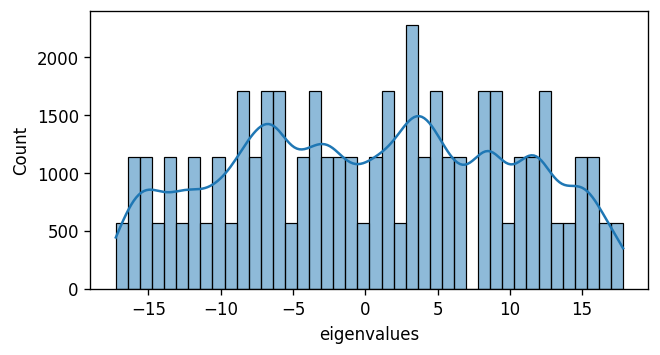

In [37]:
plt.figure(figsize=(6,3), dpi=120)
sbn.histplot(results, kde=True)

plt.xlabel('eigenvalues')
plt.savefig('hist_80_100000.png', dpi=300)

plt.show()

In [38]:
# vysledky jakz takz pro:
# - N = 80
# - num_of_experiments = 10000 a vice
# - diagonala z N(0,1), nediagonala z N(0,2)

## paralelize

In [41]:
import multiprocessing

# Define your function
def foo(a, b, c):
    # Your function logic here
    result = a + b + c
    return result

if __name__ == "__main__":
    # Number of parallel processes
    num_processes = 4  # You can adjust this to your hardware capabilities
    num_of_experiments = 2

    # Create a multiprocessing pool
    pool = multiprocessing.Pool(processes=num_processes)

    # Define the arguments for foo function
    a_values = [None] * num_of_experiments  # Example values for 'a'
    b_values = [3] * num_of_experiments  # Example values for 'b'
    c_values = [True] * num_of_experiments  # Example values for 'c'
    d_values = [13] * num_of_experiments  # Example values for 'c'\
    d_values = [13, 14]

    # Create a list of argument tuples for foo
    # args for 'experiment' func >>> (name:str = 'none', num_of_dims_of_mtx: int = 3, print_result: bool = False)
    arguments = [(name, num_of_dims_of_mtx, print_result, seed) for name, num_of_dims_of_mtx, print_result, seed in zip(a_values, b_values, c_values, d_values)]

    # Use Pool.starmap to run foo in parallel
    results = pool.starmap(experiment, arguments)

    # Close the pool (no more tasks can be added)
    pool.close()

    # Wait for all processes to complete
    pool.join()

    # 'results' will contain the results of running foo for each set of arguments
    #print(results)


[-2.2335978829329424, 5.214605212203608, 2.990924605233845]
[4.532083763379001, -1.7072678656700877, -5.684908237930518]


## END

In [ ]:
from github import Github

# Your GitHub access token
access_token = 'YOUR_ACCESS_TOKEN'

# Your repository information
repository_owner = 'aleksejalex'
repository_name = 'temp_rndmtx'

# Path to the file you want to push
file_path = 'hist_80_1000000.png'

# Create a GitHub instance using your access token
g = Github(access_token)

# Get the repository
repo = g.get_user(repository_owner).get_repo(repository_name)

# Create a new commit to add the file to the repository
with open(file_path, 'rb') as file:
    content = file.read()
    repo.create_file(file_path, 'Commit message', content)

# Optionally, you can commit and push the changes to the repository branch
# branch = repo.get_branch('main')  # Replace 'main' with your branch name
# repo.update_file('path/to/im.jpg', 'Commit message', content, branch.commit.sha)


## saving and loading python objects

### save>>

In [ ]:
import pickle

# Your list data
my_list = [1, 2, 3, 4, 5]

# Specify the file name where you want to save the list
file_name = "my_list.pkl"

# Open the file in binary write mode and save the list using pickle
with open(file_name, "wb") as file:
    pickle.dump(my_list, file)

del(my_list)

### load>>

In [ ]:
import pickle

# Specify the file name from which to load the list
file_name = "my_list.pkl"

# Open the file in binary read mode and load the list using pickle
with open(file_name, "rb") as file:
    loaded_list = pickle.load(file)

# Now, loaded_list contains the data from the saved list
print(loaded_list)


In [ ]:
from github import Github

# Your GitHub access token
access_token = 'YOUR_ACCESS_TOKEN'

# Your repository information
repository_owner = 'your_username'
repository_name = 'your_repo_name'

# Path to the file you want to push
file_path = 'path/to/im.jpg'

# Create a GitHub instance using your access token
g = Github(access_token)

# Get the repository
repo = g.get_user(repository_owner).get_repo(repository_name)

# Create a new commit to add the file to the repository
with open(file_path, 'rb') as file:
    content = file.read()
    repo.create_file('path/to/im.jpg', 'Commit message', content)

# Optionally, you can commit and push the changes to the repository branch
# branch = repo.get_branch('main')  # Replace 'main' with your branch name
# repo.update_file('path/to/im.jpg', 'Commit message', content, branch.commit.sha)


## paralel computing

In [ ]:
import multiprocessing

# Define your function that returns a list with no input parameters
def your_function(a):
    # Replace this with the actual code of your function
    result = [1, 2, 3, 4, 5]
    return result

# Number of times you want to run the function in parallel
N = 4

# Create a pool of worker processes
pool = multiprocessing.Pool(processes=N)

# Use the pool to parallelize the function execution
results = pool.map(your_function, range(N))

# Close the pool to free up resources
pool.close()
pool.join()

# Now, 'results' will be a list of lists, each containing the output of your function
print(results)


In [ ]:
import multiprocessing

# Define your function that returns a list with no input parameters
def your_function(a):
    # Replace this with the actual code of your function
    result = [1, 2, 3, 4, 5]
    return result

# Number of times you want to run the function in parallel
N = 4

# Create a pool of worker processes
pool = multiprocessing.Pool(processes=N)

# Use the pool to parallelize the function execution
results = pool.map(your_function, range(N))

# Close the pool to free up resources
pool.close()
pool.join()

# Now, 'results' will be a list of lists, each containing the output of your function
print(results)


In [ ]:
# my old way to do it >>>>>
def demonstrate_parallel():
    # Parallel in Python
    print("Let's do some for in parallel...")
    import multiprocessing
    import funforparfor

    pool = multiprocessing.Pool(processes=8)
    pool.map(funforparfor.func, range(10))
    pool.close()
    pool.join()
    print(" 'demonstrate_parallel()' has finished its job.")

In [ ]:
import multiprocessing

# Define your function
def foo(a, b, c):
    # Your function logic here
    result = a + b + c
    return result

if __name__ == "__main__":
    # Number of parallel processes
    num_processes = 4  # You can adjust this to your hardware capabilities

    # Create a multiprocessing pool
    pool = multiprocessing.Pool(processes=num_processes)

    # Define the arguments for foo function
    a_values = [1, 2, 3, 4, 5]  # Example values for 'a'
    b_values = [10, 20, 30, 40, 50]  # Example values for 'b'
    c_values = [100, 200, 300, 400, 500]  # Example values for 'c'

    # Create a list of argument tuples for foo
    arguments = [(a, b, c) for a, b, c in zip(a_values, b_values, c_values)]

    # Use Pool.starmap to run foo in parallel
    results = pool.starmap(foo, arguments)

    # Close the pool (no more tasks can be added)
    pool.close()

    # Wait for all processes to complete
    pool.join()

    # 'results' will contain the results of running foo for each set of arguments
    print(results)
